## An overview of unsupervised learning

In the previous sessions we were interested in predicting the values of a target variable $y$ given a set of predictor variables $\bf x$. Our predictions were based on previous samples, where the values of $y$ and $\bf x$ were realized, and we had "solved" cases to learn from.

In contrast, unsupervised learning can be thought of as the pursuit of **low-dimensional structure in high-dimensional data** without supervision, i.e., without explicit examples (or "solved" cases) of what the low-d structure is. 

We will start studying clustering methods. These methods aim at splitting the data in clusters such that elements within each cluster are more closely related to one another than to those assigned to other clusters. Loosely speaking, this can be thought of as _classifying_ each instance into a group membership.

We will then study algorithms to represent our data in terms of lower dimensional *continuous latent variables*, such as Principal Components Analysis. 


## Problem Setup

We have a set of $n$ observations $({\bf x}_1,\dots, {\bf x}_n)$ where $ {\bf x} \in \mathbb{R}^p$ and $p$ may be larger than $n$. Our goal is to learn the structure of ${ \bf x }$ without "solved" cases to learn from. 



## Cluster Analysis

We start with the case where we have $K$ groups, and have to assign each observation to a single group.
Central to cluster analysis is the notion of similarity (or dissimilarity) between the points being clustered. A clustering method attempts to group objects based on the definition of similarity supplied to it. Loosely speaking, this dissimilarity works as a _loss function_.

Lets start visualizing what our goal is with two simulated examples : "patches" and "cicles".

In [2]:
# load the relevant packages

import numpy as np
import math 
import pandas as pd
from sklearn.preprocessing import scale as scl
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# we will have two clusters in our data
n1 = 50 # cluster 1 will have 50 observations
n2 = 60 # cluster 2 will have 60 observations
labels = np.concatenate((np.zeros(n1), np.ones(n2)), axis = 0)

In [4]:
# the patches dataset
# define center of each cluster
mu0 = np.ones((n1, 2))*np.array([0, -0.5])
mu1 = np.ones((n2, 2))*np.array([0.3, 1])

# adding some spread around the center
e0 = np.random.randn(n1, 2)*0.3 # gaussian noise
e1 = np.matmul(np.random.randn(n2, 2), np.array([[0.3, 0.25], [0.05, 0.05]])) # linear combination of guassian random variables

patches = np.concatenate((mu0 + e0, mu1 + e1), axis = 0)

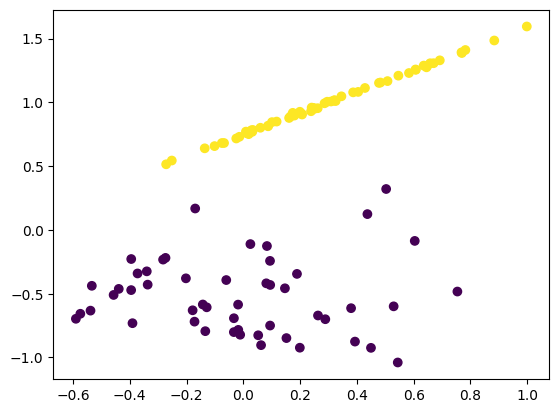

In [5]:
plt.scatter(patches[:, 0], patches[:, 1], c=labels)

In [6]:
# the circles dataset
r0 = np.random.random(n1)*0.3 + 1 # radius
theta0 = np.random.random(n1)*2*np.pi # where in the circle is the point

x00 = r0*np.cos(theta0) # semi circle
x01 = r0*np.sin(theta0) # semi circle
x0 = np.concatenate((x00.reshape((-1,1)), x01.reshape((-1,1))), axis=1)

In [7]:
r1 = np.random.random(n2) + 3 # uniformly distributed numbers
theta1 = np.random.random(n2)*2*np.pi

x10 = r1*np.cos(theta1)
x11 = r1*np.sin(theta1)
x1 = np.concatenate((x10.reshape((-1,1)), x11.reshape((-1,1))),axis=1)

circles = np.concatenate((x0, x1), axis = 0)

In [8]:
circles.shape

(110, 2)

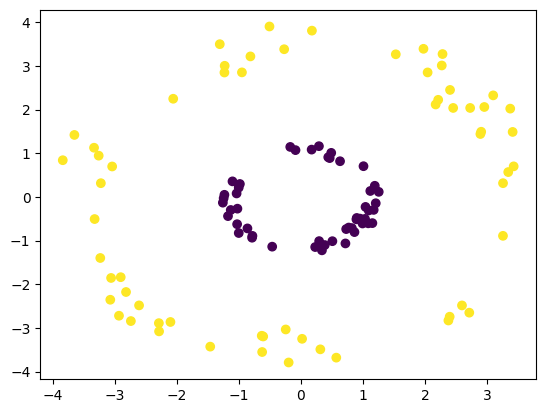

In [9]:
plt.scatter(circles[:,0], circles[:,1], c=labels)

Our objective is to _learn_ the groups from the data. Clearly, we need a notion of _(dis)similarity_ if we are to be succesful in grouping similar observations together.

## Dissimilarity matrices based on attributes

Typically, we define a dissimilarity $d_j(x_{ij},x_{i'j})$ between the values of the $j$ th attribute, and then define $ D(x_i,x_{i'}) = \sum_{j=1}^p w_j d_j(x_{ij},x_{i'j})$ with $\sum_{j=1}^p w_j =1$ as the dissimilarity between objects $i$ and $i'$. 
Typically, we set $d_j(x_{ij},x_{i'j}) = (x_{ij} -x_{i'j})^2$, but other choices are available. The choice of ${\bf w}$ is not trivial and context dependent.


## Combinatorial Clustering Algorithms

The most popular clustering algorithms assume that there is a prespecified number of clusters $K < n$, each of which is labeled with an integer $k \in \{1,\dots,K\}$, and each observation is assigned to one and only one cluster. These assignments can be characterized by an _encoder_ $k = C(i)$, that assigns the $i$ th observation to the $k$ th cluster. We then search for the $C^*(i)$ that minimizes within cluster distance as measured by $d(x_i,x_{i'})$.

A natural "loss" function to be minimized is $$ W(C) = \frac{1}{2}\sum_{k=1}^K\sum_{C(i)=k}\sum_{C(i')=k}D(x_i,x_{i'}).$$

This criterion measures the extent to which observations within the same cluster differ from each other. 
In fact, if we define the total _scatter_ of the data, which does not depend on $C(\cdot)$, we have

$$ T = \frac{1}{2}\sum_{i=1}^n\sum_{i=1}^nd(x_i,x_{i'}) = \frac{1}{2}\sum_{k=1}^K\sum_{C(i)=k}\Big( \sum_{C(i')=k}d(x_i,x_{i'}) + \sum_{C(i')\neq k}d(x_i,x_{i'}) \Big)$$

and $T = W(C) + B(C)$. We refer to $W(C)$ as the _within_ cluster scatter, and to $B(C)$ as the _between_ cluster scatter. Clearly, minimizing $W(C)$ is equivalent to maximizing $B(C)$. If we could minimize $W(C)$, our problem would be solved. However, as the name suggests, this minimization problem becomes quite complex as $n$ and $K$ grow.

## K-means clustering

If we set $d(x_i , x_{i'}) = \sum_{j=1}^p ( x_{ij}- x_{i'j})^2 = || x_i - x_{i'}||^2$, we can simplify much of our analysis. Note that 
$$ W(C) = \frac{1}{2}\sum_{k=1}^K\sum_{C(i)=k}\sum_{C(i')=k} || x_i - x_{i'}||^2 = \sum_{k=1}^K n_k\sum_{C(i)=k} || x_i - \bar x_{k}||^2.$$

where $x_k$ is the vector of within cluster averages and $n_k$ is the number of members on cluster $k$.

Our target is to find
$$ C^* =\sum_{k=1}^K n_k\sum_{C(i)=k} || x_i - \bar x_{k}||^2,$$

Noting that for any set of observations $S$, the mean minimizes the squared distance, _i.e_

$$ \bar x_S = \arg\min_m \sum_{i \in S} ||x_i-m||^2, $$

Hence, we just need to find the set of _K-means_ that minimizes the target. We can proceed as follows:

+ First, for a given cluster assignment $C_s$, the means $\{m_1,\dots,m_K\}$ minimize the total cluster variance.

+ Then, given a set of current means $\{m_1,\dots,m_K\}$, update $C_s(i)$, the encoding of observation $i$, such that
$$ C_{s+1}(i) = \arg\min_{k=1,\dots,K}||x_i - m_k||^2 $$
That is, assign each observation to the cluster with the closest mean.

+ Iterate this until the assignments do not change (_i.e._ $C_{s+1}=C_{s}$)


Lest see K-means in action in our simulated patches data

In [10]:
from sklearn.cluster import KMeans
kmeans_patches = KMeans(n_clusters = 2, 
                        algorithm = 'full',
                        max_iter = 30)
kmeans_patches.fit(patches)

c:\Users\wangc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1318: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


KMeans(algorithm='full', max_iter=30, n_clusters=2)

In [11]:
kmeans_patches.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Text(0.5, 1.0, 'Original clustering')

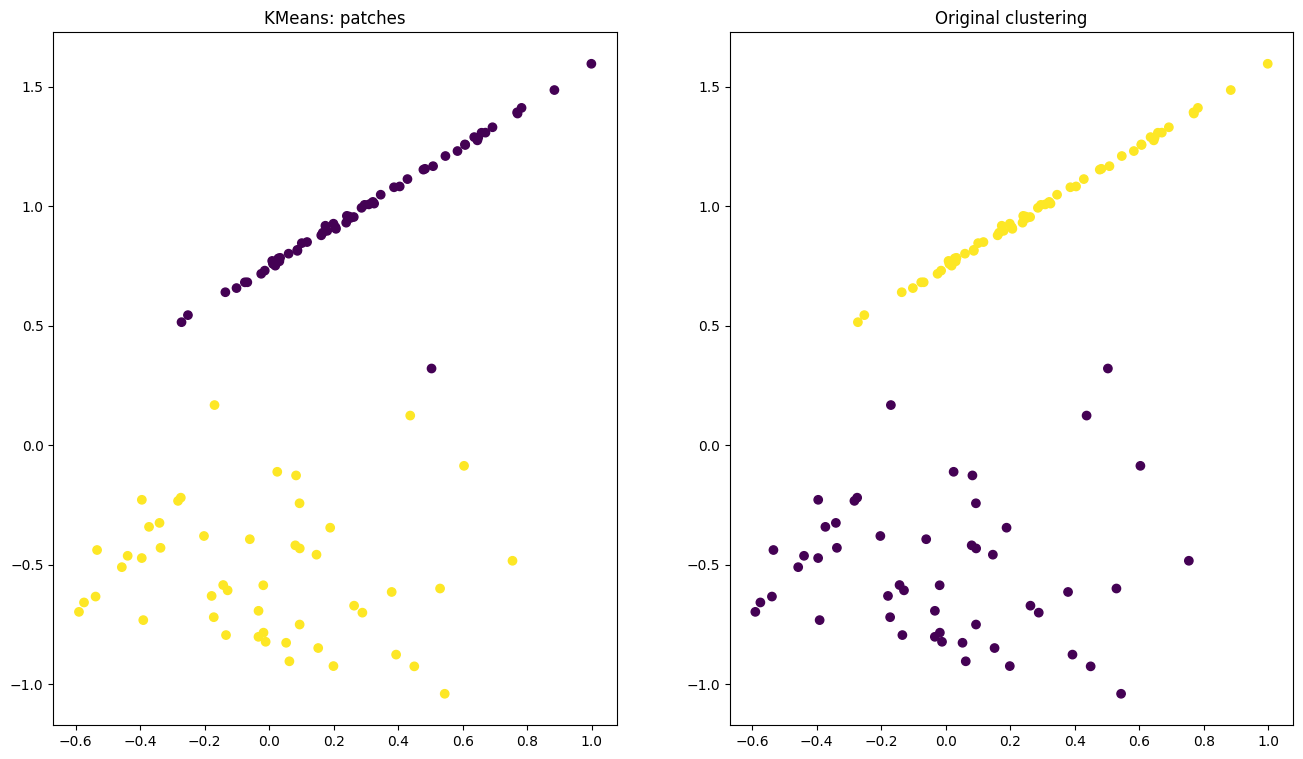

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 9))
ax1.scatter(patches[:, 0], patches[:, 1], 
            c = kmeans_patches.labels_)
ax1.set_title('KMeans: patches')
ax2.scatter(patches[:, 0], patches[:, 1], c=labels)
ax2.set_title('Original clustering')

## A closer look at K_Means

In [13]:
# Initialized at k(in this case 2) points sampled from our data
center = patches[np.random.randint(low = 0,
                                   high = patches.shape[0],
                                   size = 2)]

distances = (patches - center[0])**2, (patches - center[1])**2
labels_start = np.array([1 if distances[1][d].sum() <= distances[0][d].sum() else 0 for d in range(0, patches.shape[0])])

new_center = patches[labels_start==1].mean(axis=0), patches[labels_start==0].mean(axis=0)

distances = (patches - new_center[0])**2, (patches - new_center[1])**2
new_labels = np.array([1 if distances[1][d].sum() <= distances[0][d].sum() else 0 for d in range(0, patches.shape[0])])

final_center = patches[new_labels==1].mean(axis=0), patches[new_labels==0].mean(axis=0)

distances = (patches - final_center[0])**2, (patches - final_center[1])**2

final_labels = np.array([1 if distances[1][d].sum() <= distances[0][d].sum() else 0 for d in range(0, patches.shape[0])])

Text(0.5, 1.0, 'Finanl Interation')

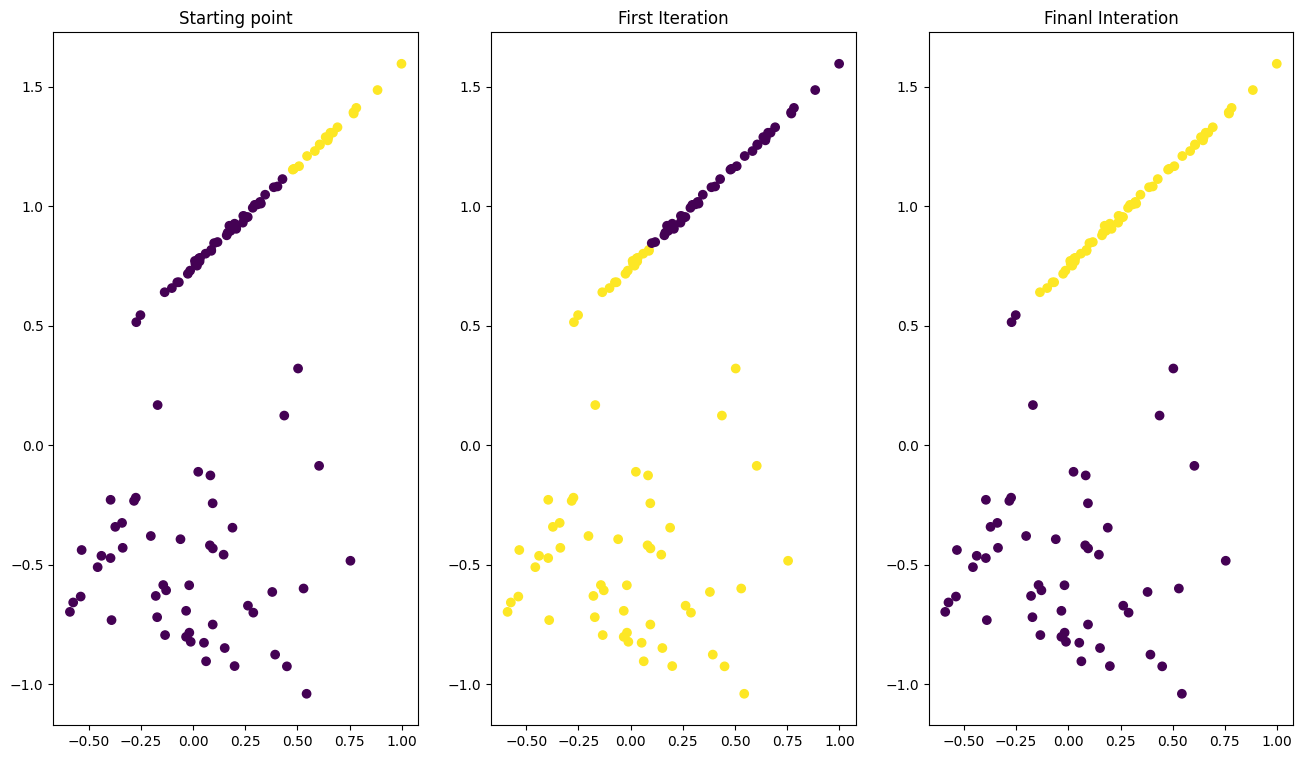

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 9))

ax1.scatter(patches[:,0], patches[:,1], c = labels_start)
ax1.set_title('Starting point')

ax2.scatter(patches[:, 0], patches[:, 1], c=new_labels)
ax2.set_title('First Iteration')

ax3.scatter(patches[:, 0], patches[:, 1], c=final_labels)
ax3.set_title('Finanl Interation')

Below we can see the algorithm at work. From Bishop's book: 

<img src="https://github.com/barcelonagse-datascience/academic_files/raw/master/images/Kmeans.png" width="800">


We are already doing a very decent job for the patches dataset. What about the circles dataset? 

In [15]:
kmeans_circles = KMeans(n_clusters = 2,
                        algorithm = 'full',
                        max_iter = 30)
kmeans_circles.fit(circles)

c:\Users\wangc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1318: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


KMeans(algorithm='full', max_iter=30, n_clusters=2)

Text(0.5, 1.0, 'Original')

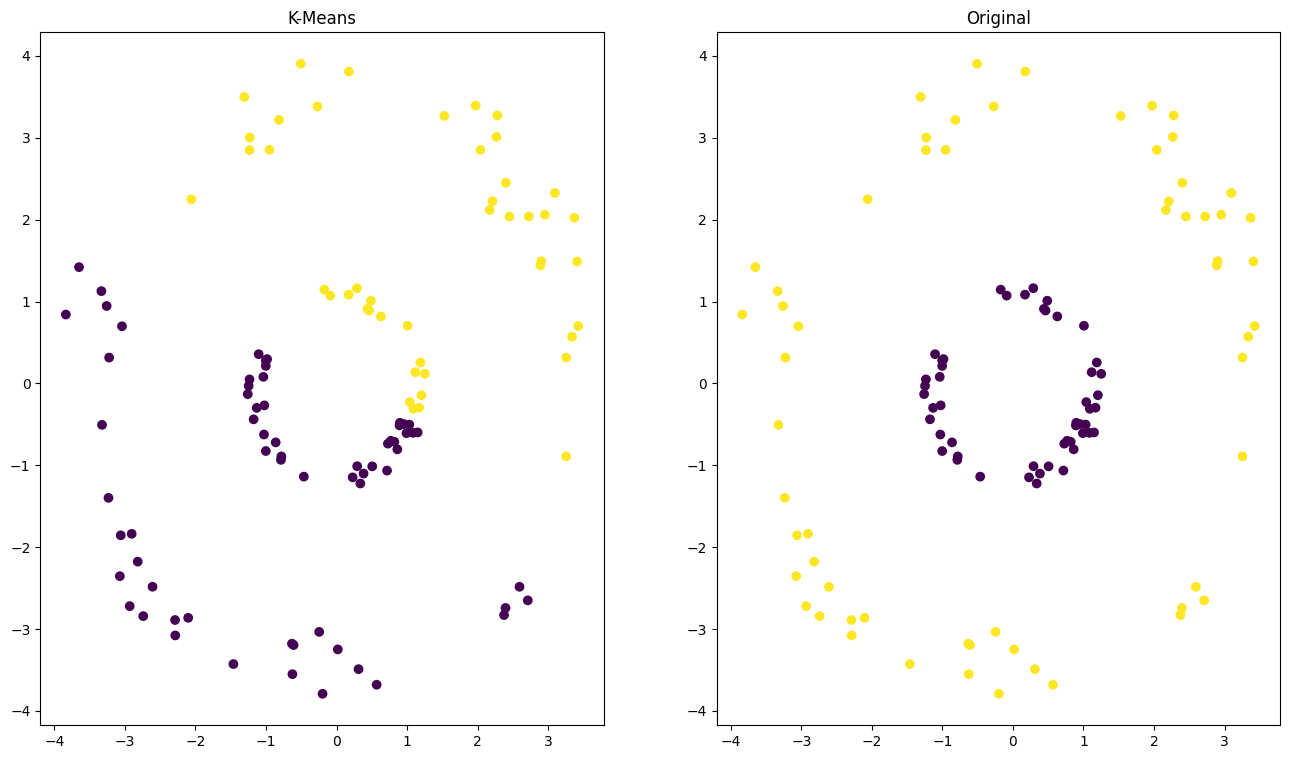

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 9))

ax1.scatter(circles[:, 0], circles[:, 1], c = kmeans_circles.labels_)
ax1.set_title('K-Means')

ax2.scatter(circles[:, 0], circles[:, 1], c = labels)
ax2.set_title('Original')

What is happening? lets see if we get a better view with our detailed code:

In [17]:
# Initialize at k(in this case: 2) points sampled form our data
center = circles[np.random.randint(low = 0,
                                   high = circles.shape[0],
                                   size = 2)]

distances = (circles - center[0])**2, (circles - center[1])**2

labels_start = np.array([1 if distances[1][d].sum() <= distances[0][d].sum() else 0 for d in range(0, circles.shape[0])])

new_center = circles[labels_start==1].mean(axis = 0), circles[labels_start==0].mean(axis = 0)

distances = (circles - new_center[0])**2, (circles - new_center[1])**2

new_labels = np.array([1 if distances[1][d].sum() <= distances[0][d].sum() else 0 for d in range(0, circles.shape[0])])

final_center = circles[new_labels == 1].mean(), circles[new_labels == 0].mean()

distances = (circles - final_center[0])**2, (circles - final_center[1])*2

final_label = np.array([1 if distances[1][d].sum() <= distances[0][d].sum() else 0 for d in range(0, circles.shape[0])])

Text(0.5, 1.0, 'Final Iteration')

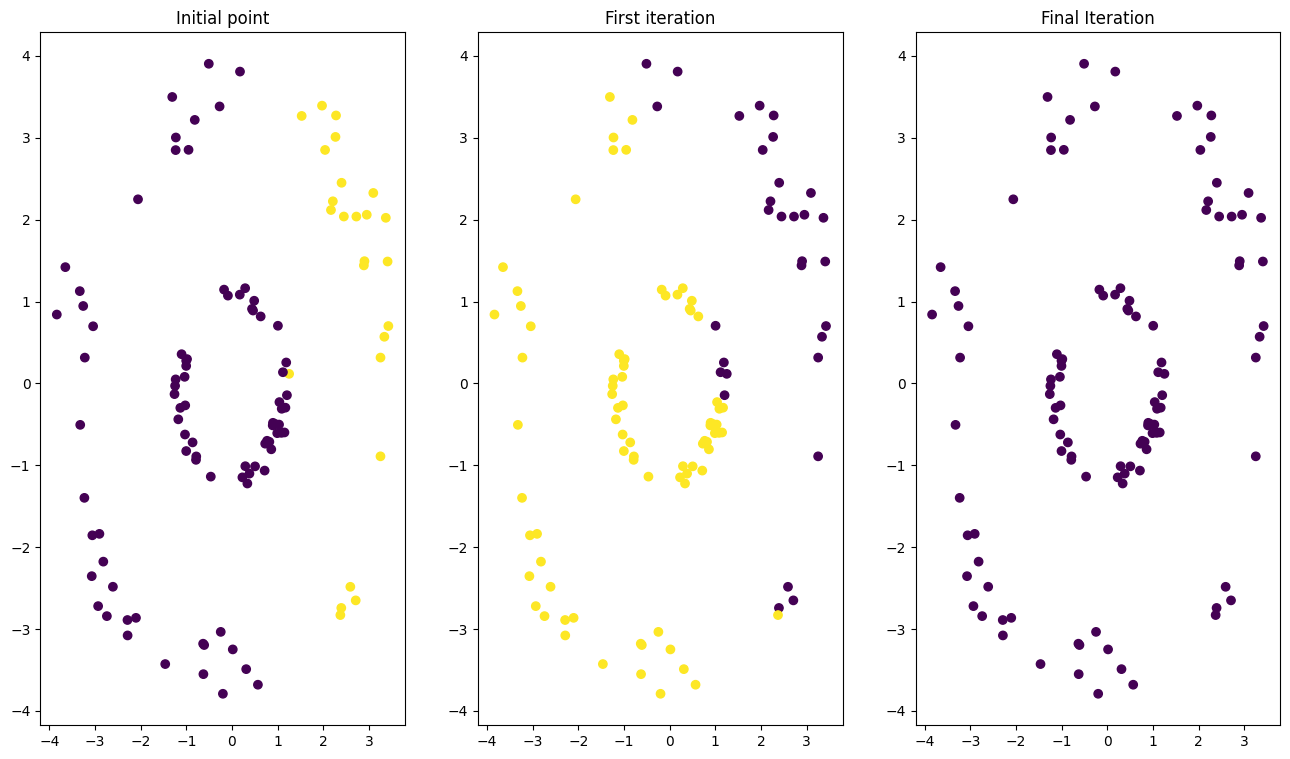

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 9))

ax1.scatter(circles[:, 0], circles[:, 1], c = labels_start)
ax1.set_title('Initial point')

ax2.scatter(circles[:, 0], circles[:, 1], c = new_labels)
ax2.set_title('First iteration')

ax3.scatter(circles[:, 0], circles[:, 1], c = final_label)
ax3.set_title('Final Iteration')

Unfortunately, we are substantially less successful in the circles dataset. 
Intuitively the points (0,4) and (0,-4), which would belong to the outer ring, are further apart than (0,4) and (0,1) or even (0,-1), for that matter. So K-Means will not be able to pick this type of graph up.

**How would you solve this problem?**

Intuitively, if we could draw a line connecting each point to its closest neighbor, we would travel, for instance, from (0,4) to (0.5,3.5), then (say) to (1,3), and so on. Importantly, the closest neighbor of each point in the outer ring would be another point in the outer ring -- and not one in the inner ring.

This is effectively what **Spectral clustering** does. It attempts to connect points based on their attributes (for instance, their neighborhoods). Points that are connected form a cluster, and there are as many clusters as _connected (sub)graphs_ in the data.

### Spectral clustering & graph-based learning

This technique has interesting intersections with a number of ideas that we will discuss : at its core is PCA, it uses discrete latent variables, it is based on a metric and distances between the data points, it uses K-means clustering. 

The key idea here is to represent the data as a **graph** and identify "low-d structure" by means of graph connectivity properties. 

This approach has very deep roots in applied mathematics. We will introduce a bit more notation to deal with this.`

#### Some graph connectivity concepts

Suppose we have a graph with $n$ nodes and weight/affinity matrix $\bf A$ where $A_{ij} ≥ 0$ is a measure of strength of the edge, and $\bf A' = \bf A$; in the simplest
case $A_{ij} ∈ {0, 1}$, for example:

<img src="https://github.com/barcelonagse-datascience/academic_files/raw/master/images/graph.png" width="400">

In [19]:
# the affinity matrix for this simple example

A = np.array([[0,1,1,0,0,0,0,0,0], # row 1 is connected to columns 2 and 3 but not itself
              [1,0,1,0,0,0,0,0,0], # row 2 is connected to columns 1 and 3 but not itself
              [1,1,0,0,0,0,0,0,0],
              [0,0,0,0,1,0,0,0,0],
              [0,0,0,1,0,0,0,0,0],
              [0,0,0,0,0,0,1,1,1],
              [0,0,0,0,0,1,0,1,1],
              [0,0,0,0,0,1,1,0,1],
              [0,0,0,0,0,1,1,1,0]])
A

array([[0, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 0]])

Consider the **graph Laplacian** matrix: 

$$\bf L = \bf B- \bf A, \quad \bf B = diag(B_1,\ldots,B_n), \quad B_i = \sum_j A_{ij} \quad $$

$B$ here is known as the degree matrix. It is a diagonal matrix with elements given by the number of edges that are connected to a node. 

In our example:

In [20]:
B = np.diag(A.sum(1))
B

array([[2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 3, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 3, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 3, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 3]])

In [21]:
L = B - A
L

array([[ 2, -1, -1,  0,  0,  0,  0,  0,  0],
       [-1,  2, -1,  0,  0,  0,  0,  0,  0],
       [-1, -1,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1, -1,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  3, -1, -1, -1],
       [ 0,  0,  0,  0,  0, -1,  3, -1, -1],
       [ 0,  0,  0,  0,  0, -1, -1,  3, -1],
       [ 0,  0,  0,  0,  0, -1, -1, -1,  3]])

$\bf L$ is called the graph Laplacian (and there are various other versions of this) 
+ $\bf L$ is positive semi-definite
+ it has a 0 eigenvalue for for each *disconnected* component (hence it is singular!)
+ the corresponding eigenvectors to a 0 eigenvalue are linear combinations of component-indicator functions

**Spectral** in **Spectral Clustering** hints that we will be using the eigenvalues of this matrix. 
In fact, we can use the eigendecomposition of our symmetric $L$ matrix into $L$ into $UBU'$.

In [22]:
U, V, Ut = np.linalg.svd(L, full_matrices = True)
np.round(V, 3)

array([4., 4., 4., 3., 3., 2., 0., 0., 0.])

First eigenvalue is 0, 3 other distinct eigenvalues, each corresponding to a cluster in our data.

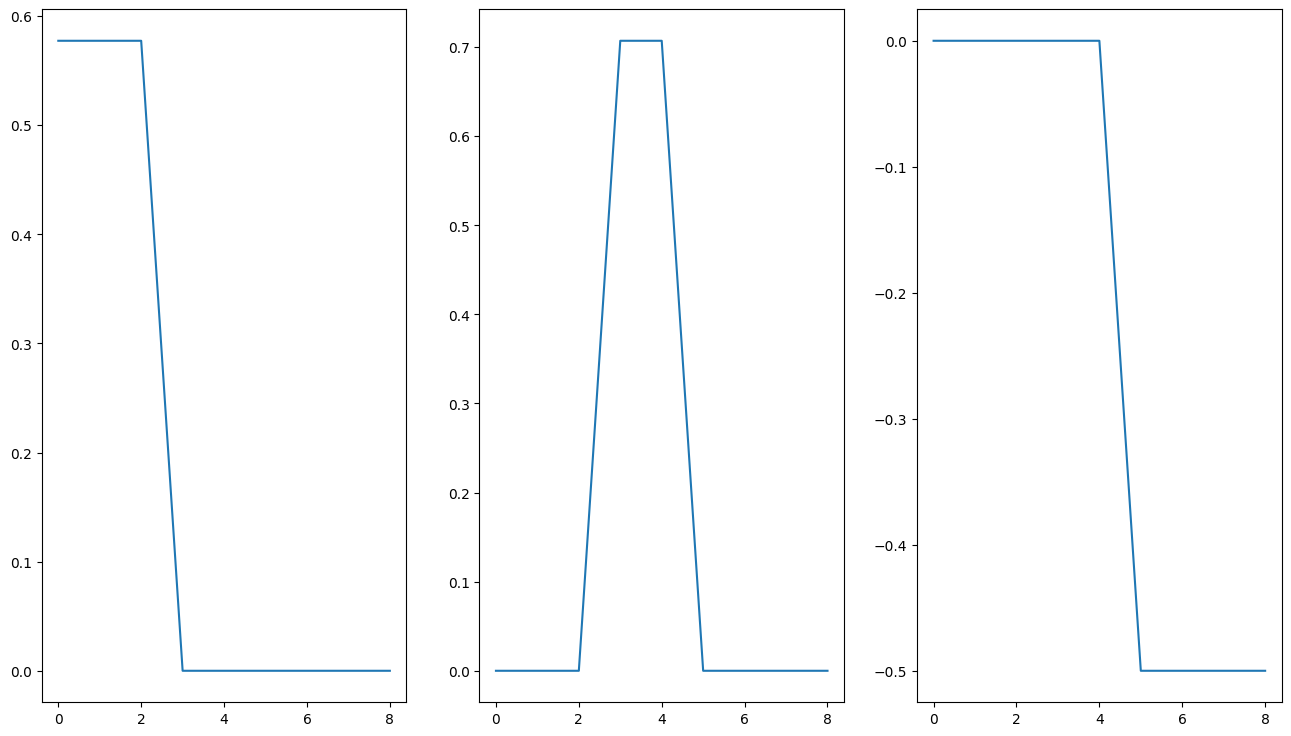

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 9))

ax1.plot(U[:, -1])
ax2.plot(U[:, -2])
ax3.plot(U[:, -3])

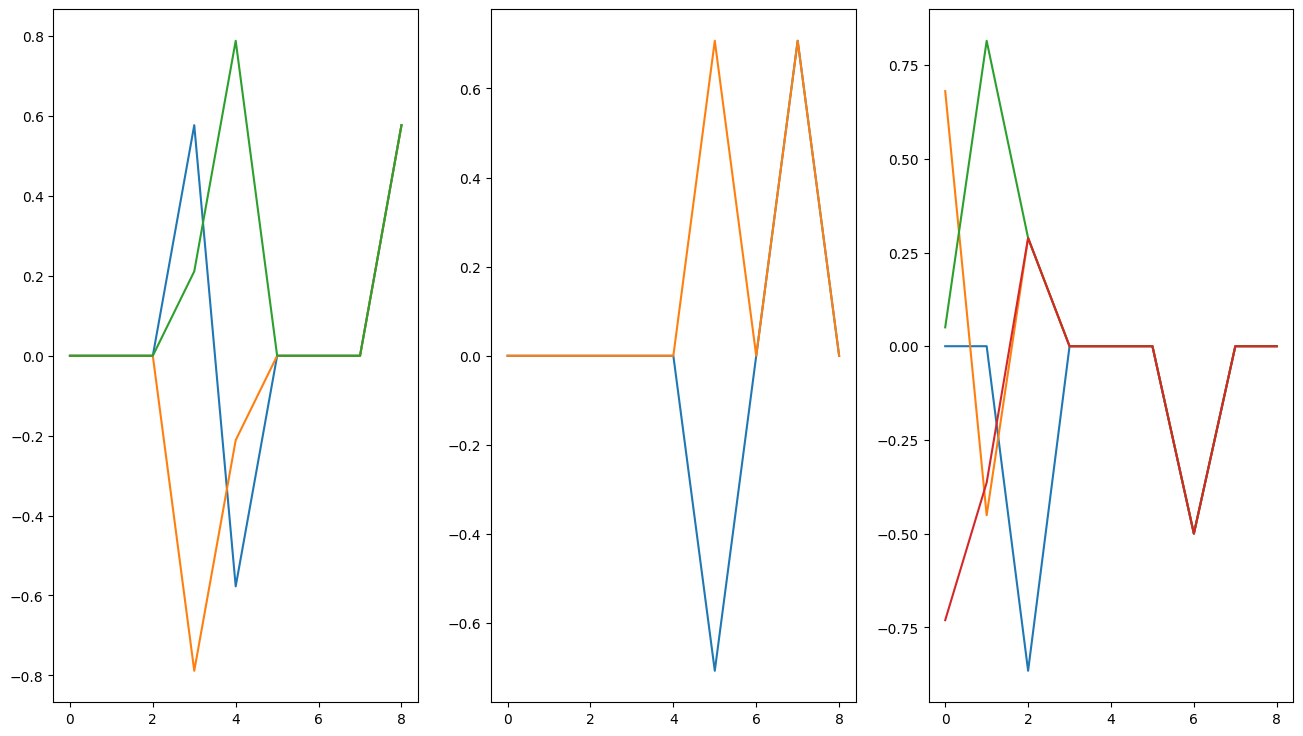

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 9))

ax1.plot(U[0, :])
ax1.plot(U[1, :])
ax1.plot(U[2, :])

ax2.plot(U[3, :])
ax2.plot(U[4, :])

ax3.plot(U[5, :])
ax3.plot(U[6, :])
ax3.plot(U[7, :])
ax3.plot(U[8, :])

### Spectral clustering: the algorithm

+ Embed data points in a graph: 
  + Use a metric $d(\bf x_i,\bf x_j)$ and use it to build an **affinity kernel**, e.g., $A_{ij} = exp\{-d(\bf x_i,\bf x_j)^2/v\}$
  + SV-decompose $L$; look for $K$ smallest singular values
  + run a clustering algorithm (e.g. K-means) in K -dimensions to cluster the values of the K eigenvectors into K groups

In [25]:
# walktrough of spectral clustering
# step 1: write a function to compute ex(-|x|^2/v) of a given vector x, use also as argument the scale v

def kernel(x, v):
  if (np.size(x) > 1): # matrix multiplication
    d = np.matmul(np.transpose(x), x)
  else: # if it is scalar just square
    d = (x)**2
  return math.exp(-d/v)

In [26]:
# step 2: create a function that from a matrix(n by p) X returns a (n by n) matrix A of affinities, use also as argument the scale v. 

def affinity(X, v):
  n,p = X.shape
  A = np.zeros((n, n))
  for i in np.arange(n):
    for j in np.arange(n):
      diff = X[i, :] - X[j, :]
      diff.reshape(p, 1)
      A[i, j] = kernel(diff, v)
  return A

In [27]:
# step 3: create a function that takes an affinity matrix and returns the graph Laplacian, 
# the k smallest sigular values and 
# the K corresponding sigular vectors,
# where K is an argument of the function

def graphspectral(A, K):
  n = A.shape[0]
  L = np.diag(np.diag(np.matmul(A, np.ones((n, n))))) - A
  U, B, Vt = np.linalg.svd(L, full_matrices = True)
  return L, B[-K:, ], U[:, -K:]

In [28]:
# step 4: create a wrapper that takes as input a data matrix X,
# a number of groups K, and a scale v, and return a vector of labels from 1 to k, one for each row of the data matrix
# call functino spectralcluster, ideally make an argument the number of iterations of Kmeans with a sensible default

def spectralcluster(X, K, v, iter=100):
  from sklearn.cluster import KMeans
  A = affinity(X, v)
  L, B, U = graphspectral(A, K)
  res = KMeans(n_clusters = K, algorithm = 'full',
               max_iter = iter).fit(U)
  return res.labels_


c:\Users\wangc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1318: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


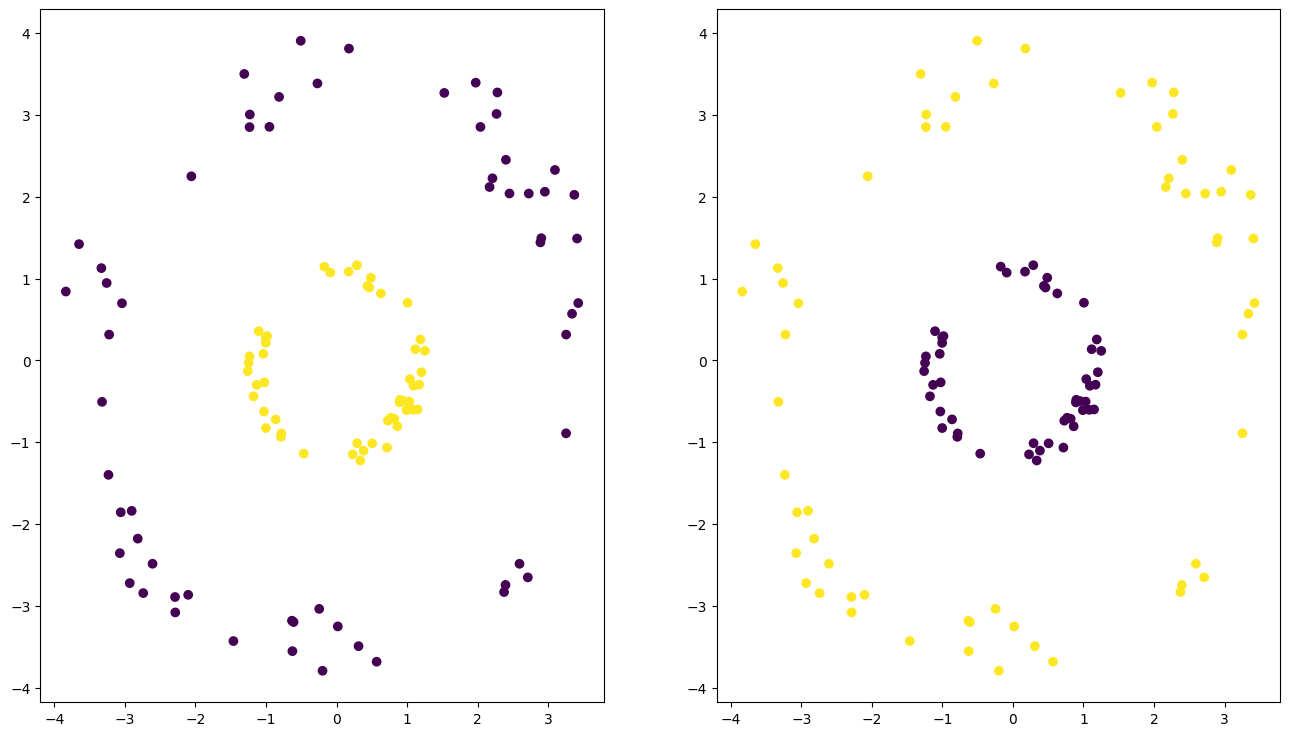

In [29]:
circles_sc_own = spectralcluster(circles, K = 2, v = 0.3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
ax1.scatter(circles[:, 0], circles[:, 1], c = circles_sc_own)

ax2.scatter(circles[:, 0], circles[:, 1], c = labels)
plt.show()

we are now able to separate the concentric circles! We could also have used sklearn.cluster

In [30]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(n_clusters = 2,
                     gamma = 1,
                     affinity = 'nearest_neighbors',
                     random_state = 44)

patches_sc = sc.fit_predict(patches)
circles_sc = sc.fit_predict(circles)

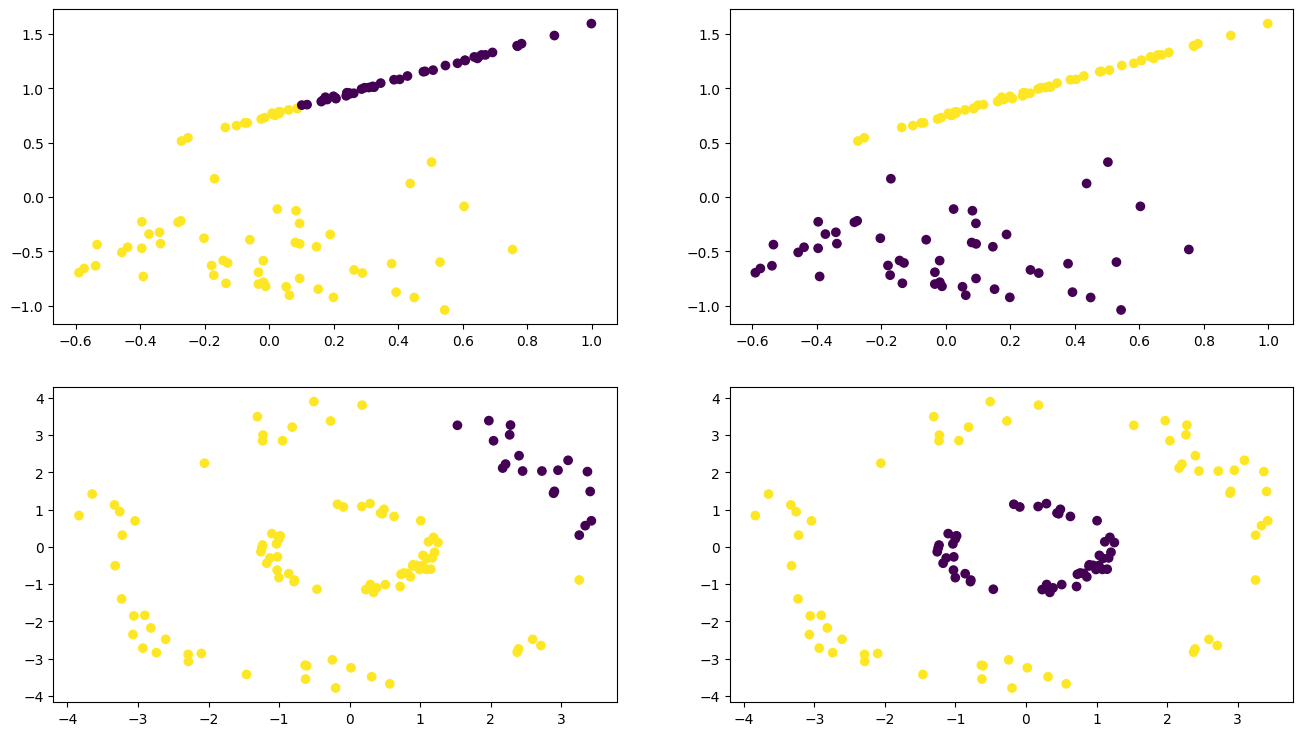

In [31]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (16, 9))

ax1.scatter(patches[:, 0], patches[:, 1], c = patches_sc)
ax2.scatter(patches[:, 0], patches[:, 1], c = labels)

ax3.scatter(circles[:, 0], circles[:, 1], c = circles_sc)
ax4.scatter(circles[:, 0], circles[:, 1], c = labels)

### Data transformations

K-means relies on Euclidean distances. This metric assumes that all variables contribute equally to distance. Scaling variables clearly has an impact on the performance of the algorithm. This has to be done with care: sometimes scaling ``erases'' information, as will be clear with the following example.


This type of standardization that is a good practice for many Statistical Machine Learning algorithms is not always a good idea here - we already have an example above - especially when we reduce the importance of a variable that is helpful in clustering. 

The following is an example from Hastie et al. that makes the same point

<img src="https://github.com/barcelonagse-datascience/academic_files/raw/master/images/scaling_is_bad.png" width="800">


Lets give it a go in our dataset to see what happens.

In [32]:
km_patches_scaled = KMeans(n_clusters = 2,
                           algorithm = 'lloyd',
                           max_iter = 300).fit(scl(patches,
                                                   with_mean = False))

km_circles_scaled = KMeans(n_clusters = 2,
                           algorithm = 'lloyd',
                           max_iter = 300).fit(scl(circles,
                                                   with_mean = False))

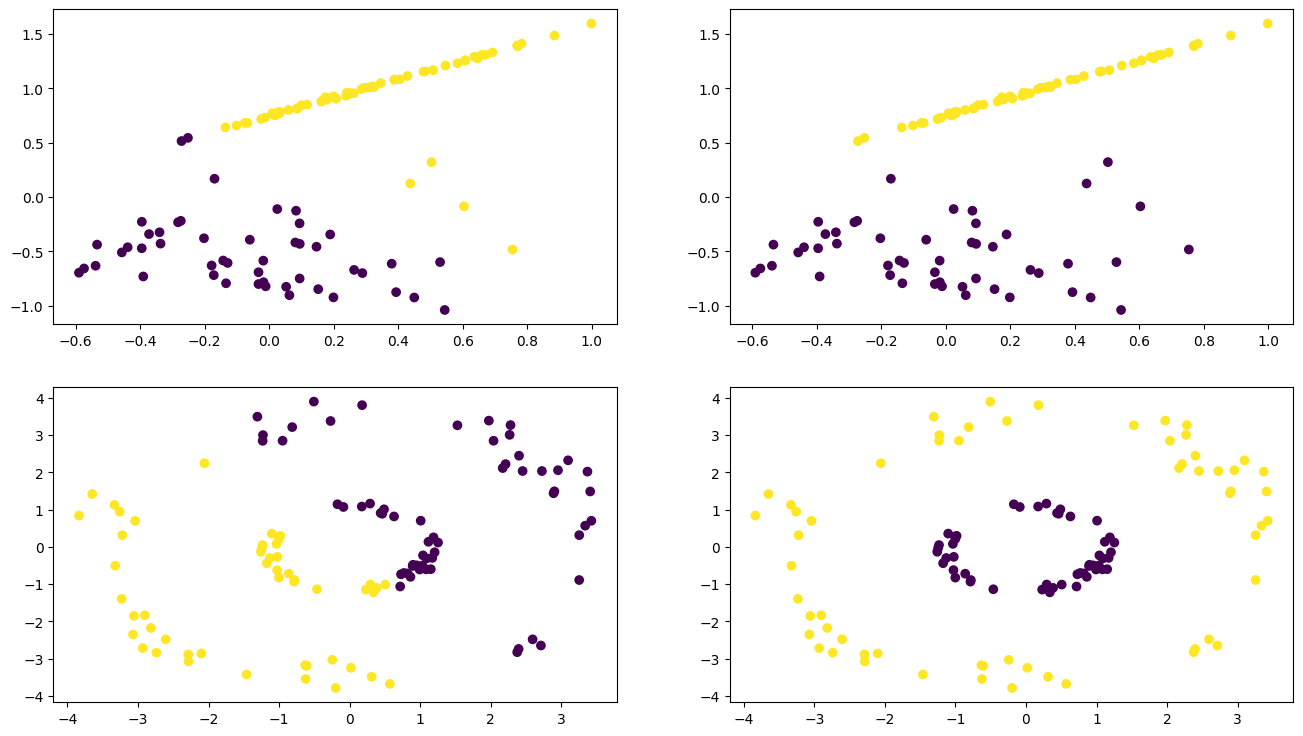

In [33]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (16, 9))

ax1.scatter(patches[:, 0], patches[:, 1], c = km_patches_scaled.labels_)
ax2.scatter(patches[:, 0], patches[:, 1], c = labels)

ax3.scatter(circles[:, 0], circles[:, 1], c = km_circles_scaled.labels_)
ax4.scatter(circles[:, 0], circles[:, 1], c = labels)

### Connection to model-based clustering

An alternative approach is to build a statistical model for observed and latent variables.

That is, we assume we have densities $p_1(\bf x),\ldots,p_K(\bf x)$, each describing a cluster. Then 

$$\bf x_i | \bf z_i \sim p_{k} (\bf x_i) \quad if \quad z_{ik}=1$$

and 

$$p(z_{ik} = 1) = \pi_k \quad \pi_k \geq 0 \quad \sum_k \pi_k =1 $$

Then, if we marginalize the latent variable we obtain a **mixture model** for $\bf x_i$:

$$p(\bf x_i) = \sum_{k} \pi_k p_k(\bf x_i)$$

If we take $p_k(\bf x) \equiv \mathcal{N}(\bf{mu_k},v \bf{I})$ K-means becomes an algorithm for computing the maximum likelihood estimate of $\bf mu_1,\ldots,\bf mu_K$ in this model. 

The interesting aspect of using Gaussian Mixtures as "soft" K-means is that we get probability assignments: each point is assigned a probability of belonging to cluster $k$, in contrast to the "hard" decision of $K-means$. This is an illustration from Bishop: 

<img src="https://github.com/barcelonagse-datascience/academic_files/raw/master/images/EM_Gauss.png" width="800">


## Clustering: Out-of-the-shelf portfolio of clustering methods

In practical terms, if our goal is to cluster a dataset into groups, we have these popular choices:
+ Partitioning Methods (k-means, PAM-  Partitioning Around Medoids)
+ Hierarchical Clustering
+ Affinity propagation
+ Mean shift
+ Spectral Clustering
+ Density-based: DBSCAN, HDBSCAN

There is a wide variety that can be explored in Python packages and modules [`sklearn.clustering`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster), [`sklearn_extra.cluster`](https://scikit-learn-extra.readthedocs.io/en/latest/api.html#clustering) and [`hdbscan`](https://hdbscan.readthedocs.io/en/latest/index.html).

Note that **metrics** to compute distances between observation can be very relevant, check the documentation (typical default is euclidean distance). Besides that, **scaling** your inputs may be necessary.

We will showcase some methods with a simple 2-D dataset, but those could be also applied to higher-dimensional dataset with two remarks:
- If there are non-numerical features in the dataset (e.g. categories), they have to be transformed to numerical. Check category encoding methods
- Dimensionality reduction techniques prior to clustering might be useful.

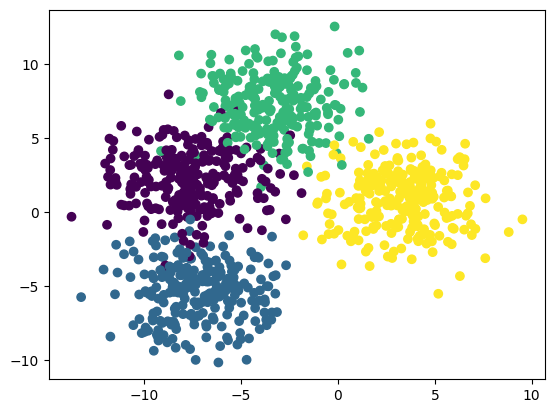

In [34]:
# create sample dataset
from sklearn.datasets import make_blobs

X, labels_true = make_blobs(n_samples = 1000,
                            centers = 4,  # number of groups
                            cluster_std = 2.0,
                            random_state = 43)
# plot dataset
plt.scatter(X[:, 0], X[:, 1], c = labels_true)

### Partitioning methods

Those methods iteratively split our dataset in subspaces, and then recompute a new centroid of the groups, and than resume again the partitioning. Note that those require that one specifies the number of clusters to be generated.

### K-Means in practice
We have seen what K-Means does, but how do we know the number of clusters in our data?

Below are some methods to help us out.
+ *Elbow method*: Compute within cluster sum of squares for a range of number of clusters and plot it. It would be a decreasing line. Then pick the number where we observe an elbow, i.e. where increasing the number of clusters is not adding a sensible decrease in WCSS. Similar concept than variance explained of PCA.


Text(0.5, 1.0, 'Elbow Method using Inertia')

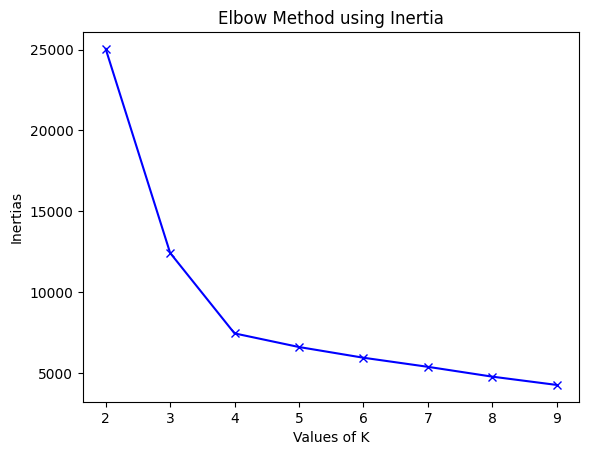

In [35]:
inertias = []
K = range(2, 10)

for i in K:
  KmeanModel = KMeans(n_clusters = i).fit(X)
  inertias.append(KmeanModel.inertia_)
  
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertias')
plt.title('Elbow Method using Inertia')

From k = 4 decrease in inertia (WCSS) becomes linear, so we select k = 4, lets plot the result.

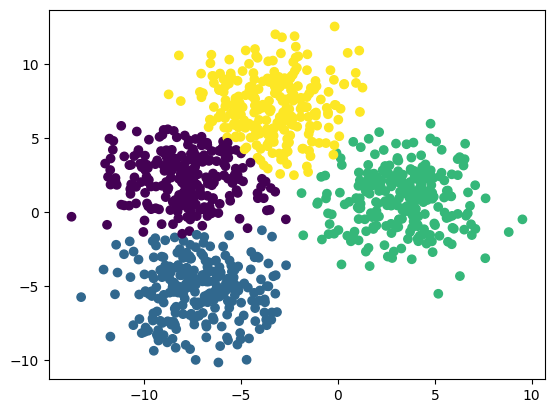

In [36]:
# results of selecting k = 4
kmeanModel = KMeans(n_clusters = 4).fit(X)
predicted = kmeanModel.predict(X)

# plot
plt.scatter(X[:, 0], X[:, 1], c = predicted)

+ *Silhouette Coefficient*: The Silhouette Coefficient is defined for each observation of the dataset and is composed of two quantities:
   +  $a$: The mean distance between a sample and all other points in the same cluster.
   +  $b$: The mean distance between a sample and all other points in the next nearest cluster.
   $$ s= \frac{b-a}{max(a,b)} $$
   Values range from 1 (best) to -1 (worst). Values near 0 indicate overlapping clusters.
   The larger $b$ and smaller the $a$ the better separation achieved.

Max average silhouette score is: 0.53163 for n_cluster = 4


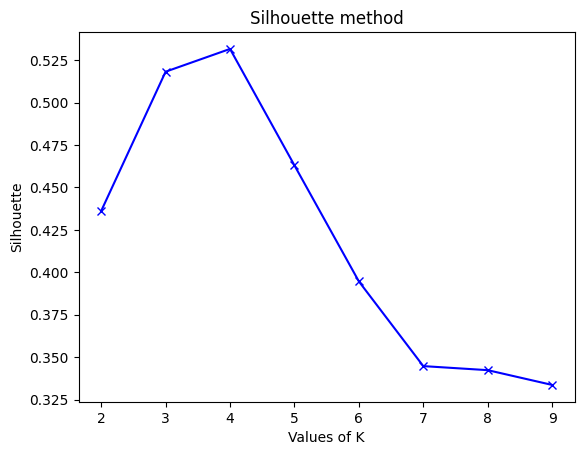

In [37]:
from sklearn.metrics import silhouette_score

silhouette_by_k = []
for i in K:
  clusterer = KMeans(n_clusters = i)
  cluster_labels = clusterer.fit_predict(X)
  
  silhouette_avg = silhouette_score(X, cluster_labels)
  silhouette_by_k.append(silhouette_avg)
  
plt.plot(K, silhouette_by_k, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette')
plt.title('Silhouette method')

print('Max average silhouette score is: %s' % round(max(silhouette_by_k), 5), 'for n_cluster = %s' % K[silhouette_by_k.index(max(silhouette_by_k))])

In this case the recommendation would have been 4 clusters, whereas k=3 would have been the second best recommendation.

Find an example with a more complete visualization of results [here](https://towardsdatascience.com/k-means-clustering-how-it-works-finding-the-optimum-number-of-clusters-in-the-data-13d18739255c).

+ *Gap statistics*. This method was defined by [Tibshirani *et al.* (2001)](https://statweb.stanford.edu/~gwalther/gap), and main formula is:
$$K^*= \underset{K}{\operatorname{argmin}} \left\{K | G(K) \geq G(K+1) + s'_{K+1}\right\} $$

that can be interpreted as follows: we will select a particular number of clusters K such that the within-cluster distance improvement of selecting one more cluster is below a threshold term $s'_{K+1}$.

There are some implementations in Python like [`gap-stat`](https://github.com/milesgranger/gap_statistic). Here is an example adapted to our case.

In [38]:
from gap_statistic import OptimalK

optimalK = OptimalK()
n_clusters = optimalK(X, cluster_array = np.arange(1, 10))

print('Optimal clusters: %s' % n_clusters)

Optimal clusters: 4


c:\Users\wangc\AppData\Local\Programs\Python\Python310\lib\site-packages\gap_statistic\optimalK.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gap_df = gap_df.append(
c:\Users\wangc\AppData\Local\Programs\Python\Python310\lib\site-packages\gap_statistic\optimalK.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gap_df = gap_df.append(
c:\Users\wangc\AppData\Local\Programs\Python\Python310\lib\site-packages\gap_statistic\optimalK.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gap_df = gap_df.append(
c:\Users\wangc\AppData\Local\Programs\Python\Python310\lib\site-packages\gap_statistic\optimalK.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. U

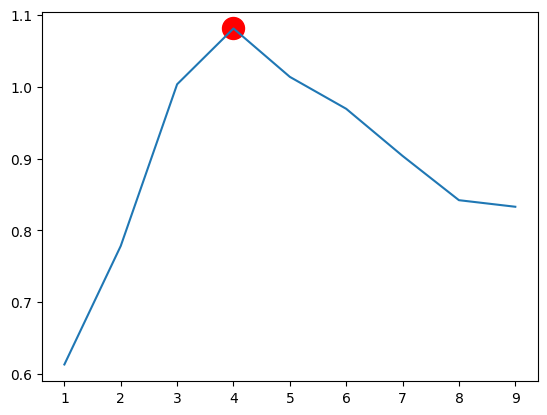

In [39]:
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value)

plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value,
            s = 250,
            c = 'red')

In [40]:
optimalK.gap_df.head(6)

,n_clusters,gap_value,ref_dispersion_std,sk,gap*,sk*,diff,diff*
0,1.0,0.613478,677.397527,0.008906,40184.641461,46407.819410,-0.145084,44767.454626
1,2.0,0.778456,944.525913,0.019894,29510.977401,34093.790566,-0.206360,32842.415493
2,3.0,1.003411,545.111824,0.018595,21483.142307,24814.580399,-0.068194,23726.224103
3,4.0,1.081051,178.903001,0.009446,14491.266140,16734.347936,0.090748,16324.047014
4,5.0,1.013715,377.236906,0.023412,11802.293611,13635.074485,0.049051,13341.503834
5,6.0,0.969271,63.983466,0.004607,9948.075471,11487.285695,0.092999,11205.632862


In this implementation, the default output is corresponding simply to the number of clusters with highest `gap_value`(G). A strict application of the original paper would imply to select as optimum cluster the minimum value of `n_clusters` that have a positive diff. in our case this would imply a result of **4 clusters** as the optimum. In any case, main decision is between n=3 and n=4 clusters.



### PAM (Partitioning Around Medoids)

This one is very similar to k-means, but now k-medoids chooses existing data points as centers (*medoids*), while in k-means the centre of a cluster is not necessarily one of the input data points.

One can use Python method [`sklearn_extra.cluster.KMedoids`](https://scikit-learn-extra.readthedocs.io/en/latest/generated/sklearn_extra.cluster.KMedoids.html#sklearn_extra.cluster.KMedoids).

### Hierarchical clustering (Aglomerative clustering)

Another popular clustering method that builds a dendrogram of the entire dataset, comparing pairwise distances between observations. It merges recursively observations based on a measure of similarity. Compared to kMeans, we don't have to define the number of clusters upfront. Nevertheless, after observing the dendrogram, we'll have to choose a cut-off point that indirectly with determine the number of clusters.

This sort of clustering can be computed in two steps:

* 1) Plot the dendrogram to decide either the number of clusters or the cut-off value
* 2) Cluster using [`sklearn.cluster.AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html), check the documentation to understant the effect of certain parameters, in particular `affinity`, `connectivity` and `linkage`. Check the effect of using connectivity in [this example](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_clustering.html#sphx-glr-auto-examples-cluster-plot-agglomerative-clustering-py).


In [41]:
import scipy.cluster.hierarchy as sch

# lets create a dendrogram
# variable linkage is actually the algorithm itself of hierarchical clustering

links = sch.linkage(X, method = 'ward')
# ward method is a method that tries to minimize the variance within each cluster

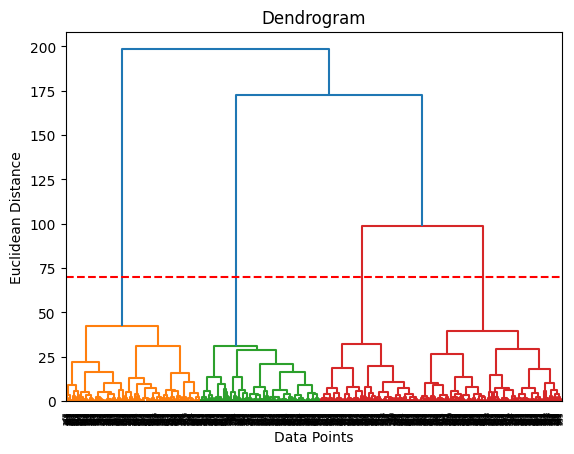

In [42]:
datasetdendrogram = sch.dendrogram(links)

plt.title('Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance')
plt.axhline(y = 70, color = 'r', linestyle = '--')

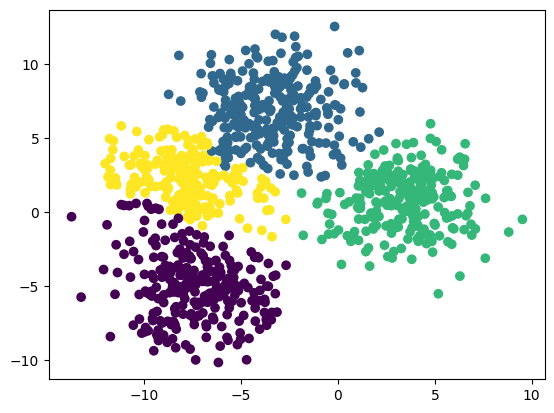

In [43]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(affinity = 'euclidean',
                             linkage = 'ward',
                             distance_threshold = 70,
                             n_clusters = None)

predicted = hc.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c = predicted)

### Affinity propagation

Affinity Propagation is a clustering algorithm that uses a graph based approach to let points ‘vote’ on their preferred ‘exemplar’. The end result is a set of cluster ‘exemplars’, observations that act as a centroid of a cluster (i.e. it's the 'exemplar' is the observation that has higher affinity to a bunch of observations that form a particular cluster).

There is no need to define a priori the number of clusters. Affinity may be defined by euclidean distance or any other affinity measure.

Check details in the [original paper](https://science.sciencemag.org/content/315/5814/972).

In [44]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(damping = 0.9,
                         preference = -1000)

clustering = af.fit(X)

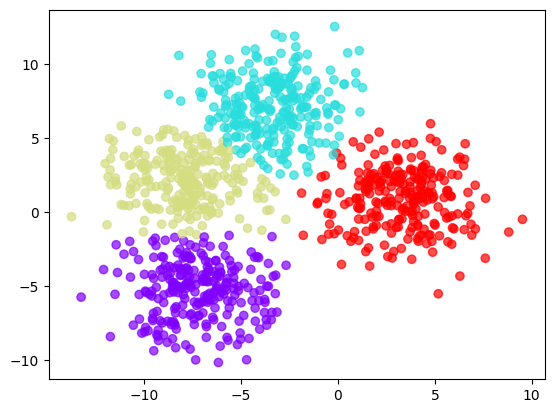

In [45]:
plt.scatter(X[:, 0], X[:, 1],
            c = clustering.labels_,
            cmap = 'rainbow',
            alpha = 0.7)

### Mean shift

Mean shift clustering involves finding and adapting centroids based on the density of examples in the feature space. 

There is no need to pre-define the number of clusters, but it is mainly dependant on the selected bandwidth of the kernel used to detect distributions, and it works well for 'globular' clusters (ideally coming from multiple Gaussian distributions).

Check details in the [original paper](https://www.computer.org/csdl/journal/tp/2002/05/i0603/13rRUxYrbVE).

In [46]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# instantiate the model
# model = MeanShift() # this is an automatic banwidth

# alternative: function to estimate bandwidth
bandwidth = estimate_bandwidth(X, quantile = 0.1)
model = MeanShift(bandwidth = bandwidth)

# fit the model and predict clusters
predicted = model.fit_predict(X)

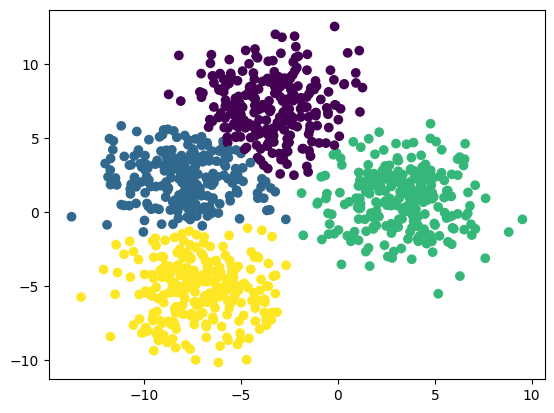

In [47]:
plt.scatter(X[:, 0], X[:, 1], c = predicted)

### Spectral clustering

Already discussed previously, so let's see in action

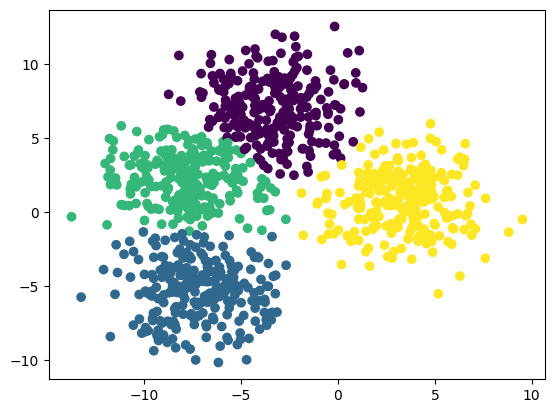

In [48]:
from sklearn.cluster import SpectralClustering

spec = SpectralClustering(n_clusters = 4, # remove this, it will try to automatically infer best number
                          assign_labels = 'discretize')

predicted = spec.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c = predicted)

Remember that we can do our own exploration of eigenvalues to select the number of clusters, starting by an estimate of scale parameter ($\nu$).


### DBSCAN

DBSCAN Clustering (Density-Based Spatial Clustering of Applications with Noise) involves finding high-density areas in the domain and expanding those areas of the feature space around them as clusters.
Observations that are far from these dense regions are classified as *noise*.

Main parameter to tune is $\epsilon$ (`eps`) which is a cut-off threshold to apply to a dendrogram of observations (similar to hierarchical clustering) but based on linkages between observations in a transformed space. A second parameter to define is `min_samples`, which is the number of samples in a neighborhood for a point to be considered as a core point


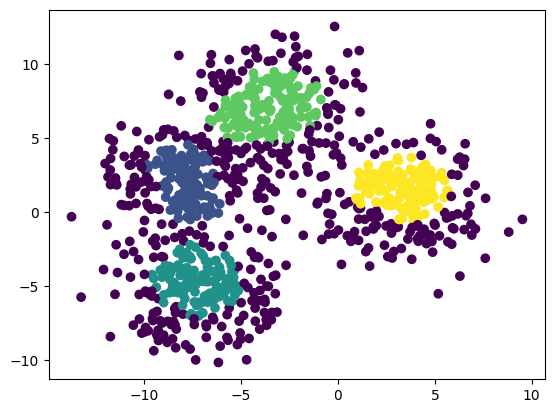

In [49]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps = 0.9, min_samples = 20)

predicted = model.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c = predicted)

There is a variation of DBSCAN that allows for clusters with **different density**. Find details in [HDBSCAN library](https://hdbscan.readthedocs.io/en/latest/index.html) documentation.

# Continuous latent variables

Clustering can be seen as assigning a discrete latent variable representing a group to each observation. 

Instead of assigning each observation to its own group, it is sometimes the case that our data $\bf X \in \mathbb{R}^p$ can be represented, or compressed, into a lower dimensional structure. We will study ways of achieving dimension reduction that have some optimality properties.




## PCA

### Breaking down PCA 
This analysis is adapted from:https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues

At the most basic level, PCA is a tool to summarize our data. It relies on the idea that many of the characteristics (features) of each row are redundant -- implying that our dataset can be represented in a smaller dimensional space.

Importantly, PCA is not selecting which features are relevant. It is _creating_ linear combinations of columns that are the most relevant. But PCA itself retains the same dimensions as before. The key idea is that now these features are ordered according to their relevance in our data, and we might not lose much by dropping a few (or even many!).


## PCA: Details

In what follows, we will assume that each column in our data has mean 0.

Suppose you are interested in finding the best $q$ dimensional representation of your $p$ dimensional data. One way which you could go about this is by finding the solution to the following least squares problem

$$ \min_{V_q, \{\lambda_i\}} \sum_{i=1}^n||X_i - V_q\lambda_i||^2 $$
where $V$ is a $p \times q$ matrix with $q$ orthogonal unit vectors as columns
and $\lambda$ is a $q \times n$ vector. This least squares solution is equivalent to minimizing the _reconstruction error_: the error obtained from representing $\bf X$ in a $q\leq p$ space.

We can partially optimize over $\{\lambda_i\}$ to get
$$\hat \lambda_i = V_q'\bf{X}_i $$

and all that is left is to find the orthogonal matrix $V_q$ such that

$$ \min_{V_q} \sum_{i=1}^n||X_i - V_qV_q'{X}_i||^2 $$

using the Singular Value Decomposition, we can write $\bf{X} = UDV'$, where:
+ $U$ is a  $n\times p$ orthonormal matrix ($U'U=I_p$); The columns of $U$ span the column space of $X$
+ $V$ is a $p \times p$ orthogonal matrix ($V'V=I_p$); The columns of $V$ span the row space of $X$.
+ $D$ is a diagonal matrix with diagonal elements $d_1\geq d_2 \geq d_p \geq 0$.

For each $q$, the solution $V_q$ is given by the first $q$ columns of $V'$, and the $n$ lambdas are the the $n$ rows of the $n\times q$ matrix $U_qD_q$, the principal components of $\bf{X}$.

The columns of $V$ define *a new coordinate system*;
The coordinates of the original data points $\bf x_i$ in this new coordinate system are 

$$(D_{1} U_{i,1},D_{2} U_{i,2},\ldots,D_{p} U_{i,p})^T$$

Another way of arriving at the same results is by realizing that
\begin{align*}
\min_{V_q} \sum_{i=1}^n||X_i - V_qV_q'{X}_i||^2 &= \min_{V_q} \Big(-\sum_{i=1}^n X_i'V_qV_q'X_i \Big)\\
&= \max_{V_q} \Big(\sum_{i=1}^n X_i'V_qV_q'X_i\Big)
\end{align*}
This implies that the PCA solution both _minimizes reconstruction error_ and _maximizes the projected variance_.


### Two synthetic examples
In order to do a little experimentation we will generate two synthetic data matrices. 

**Dataset-small**: $n=100$ observations of $p=2$ variables; this is a toy dataset for understanding concepts in an elementary way. In this example we can plot the data and this is helpful - and of course not an option in real problems!

**Dataset-large**: $n=100$ observations of $p=1000$ variables; this is realistic case of high-d data; we cannot plot so have to rely on real methods to extract information. 

The way we will simulate the data matrix is indicative of a type of low-d structure hidden in high-d data. 

In [54]:
# dataset-small
n = 100
# n draws from a standard normal
Z_small = np.random.randn(n, 1)

X1 = 2*Z_small
X2 = -1*Z_small

X = np.concatenate((X1, X2), axis = 1)
X_small = X + 0.1*np.random.randn(n, 2)

In [59]:
# dataset-large
p = 1000

Z_large = np.random.randn(n, 2)
L1 = 4*np.random.rand(2, 30)

X1 = np.matmul(Z_large, L1)
X2 = np.random.randn(n, (p - 30))

X = np.concatenate((X1, X2), axis = 1)
X_large = X + 0.05*np.random.randn(n, p)

In [60]:
# dimensions check
(Z_large.shape, L1.shape, X1.shape, X2.shape, X_large.shape)

((100, 2), (2, 30), (100, 30), (100, 970), (100, 1000))

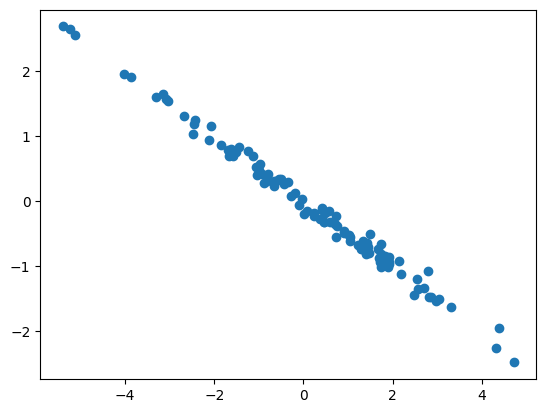

In [61]:
# plot the 2-d dataset
plt.scatter(X_small[:, 0], X_small[:, 1])

A lot of information about the structure of our data can be assessed from the covariance. The covariance matrix for the large case is:

<AxesSubplot: >

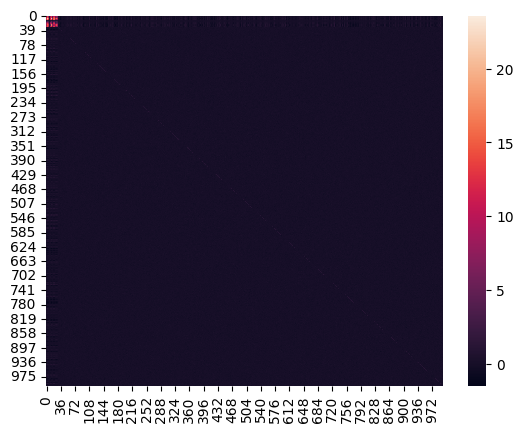

In [62]:
sns.heatmap(np.cov(X_large.transpose()))

Or, zooming into the first 80 rows and (columns)

<AxesSubplot: >

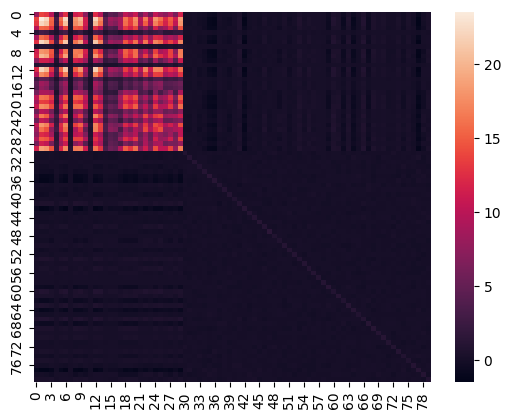

In [63]:
sns.heatmap(np.cov(X_large[:, :80].transpose()))

Visually, out of the 1000 columns we have 30 are correlated and there is not much pattern left on the rest (as we would expect).

In [64]:
# SVD for the small synthetic example
Us, Ds, Vt = np.linalg.svd(X_small) # s for small, t for tanspose!

Vs = Vt.transpose()

# print the new coordinate vectors
print(Ds)
# the largest singular value (d_1) clearly represents a lot of the variability of the data.

[23.21157831  0.88192064]


(-4.0, 4.0)

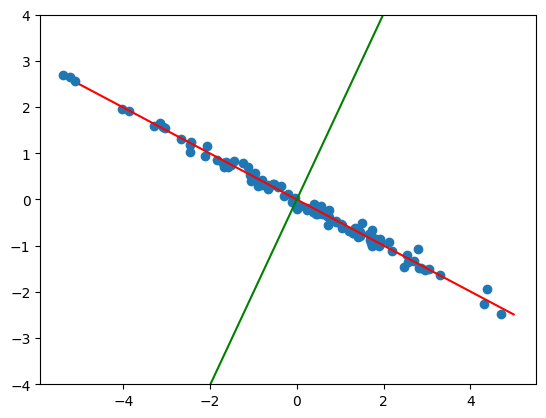

In [72]:
# lets plot the 2-d data and superimpose the new axes:
fig = plt.figure()
plt.scatter(X_small[:, 0], X_small[:, 1])

xx = np.linspace(-5, 5,10)
beta1 = Vs[1,0]/Vs[0,0]
beta2 = Vs[1,1]/Vs[0,1]

plt.plot(xx, beta1*xx, 'r') # the largest singular value
plt.plot(xx, beta2*xx, 'g') # the second largest singular value
plt.ylim(-4, 4)

Note that most of the variation on our cloud is explained by variation along the red axis, and only a small remainder by variation along the green axis.

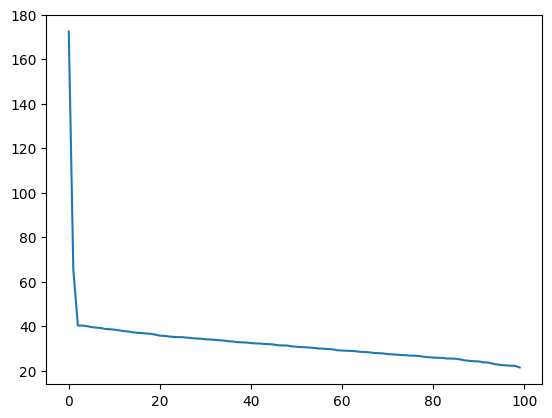

In [83]:
# SVD for the large synthetic example

Ul, Dl, Vt = np.linalg.svd(X_large)
Vl = Vt.transpose()

#
plt.plot(Dl) 

### Dimension reduction  - compression - encoding

Consider the dataset-small toy example. If we register the data in the new data-chosen coordinate system, the 2nd axis "adds very little to tell the data apart", their essential differences are captured by their coordinates in the first axis. 

Therefore, if we wanted to reduce their dimension from 2 to 1, we could represent each data point $i$ by their value on the first axis, i.e., associate a **latent coordinate** 

$$z_i = D_{11} U_{i,1}$$ 

Lets do precisely this for the dataset-small

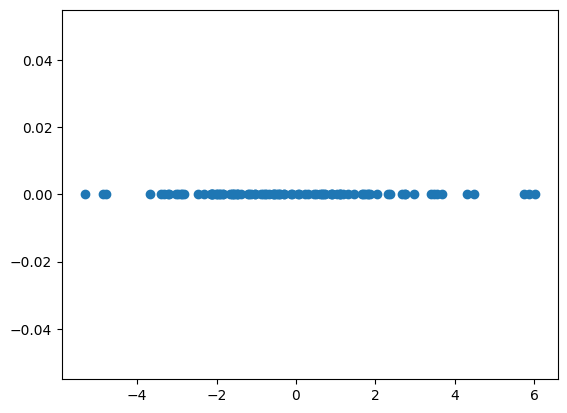

In [87]:
fig = plt.figure()
plt.plot(Ds[0]*Us[:,0], np.zeros(n), 'o')